<a href="https://colab.research.google.com/github/marianna718/Segmentation_pedesterian/blob/main/Road_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [25]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper
import kagglehub
from torch.utils.data import Dataset, DataLoader
import json
import glob
import os


In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 35.62 MiB/s, done.
Resolving deltas: 100% (3/3), done.


## Dataset for Lane detection

In [3]:

# # Download latest version
# path = kagglehub.dataset_download("manideep1108/tusimple")

# print("Path to dataset files:", path)

In [4]:
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mariannamomchyan","key":"40acab85b0fb1ed82261c4afbe22a204"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions


In [6]:
!kaggle datasets list


ref                                                               title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
atharvasoundankar/chocolate-sales                                 Chocolate Sales Data 📊🍫                            63KB  2025-03-07 05:44:03           2008         29  1.0              
abdulmalik1518/mobiles-dataset-2025                               Mobiles Dataset (2025)                             20KB  2025-02-18 06:50:24           9042        162  1.0              
asinow/car-price-dataset                                          Car Price Dataset                                 135KB  2025-01-26 19:53:28          26205        413  1.0              
mahmoudelhemaly/students-grading-dataset                    

In [7]:
!kaggle datasets download -d manideep1108/tusimple


Dataset URL: https://www.kaggle.com/datasets/manideep1108/tusimple
License(s): copyright-authors
100% 21.6G/21.6G [02:13<00:00, 224MB/s]
100% 21.6G/21.6G [02:13<00:00, 174MB/s]


In [8]:
# from google.colab import files
# files.upload()  # This will prompt you to upload zip dataset


In [9]:
!unzip /content/tusimple.zip -d /content/tusimple/


Streaming output truncated to the last 5000 lines.
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/115/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/1150/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/11520/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/1155/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/11580/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/1160/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/11640/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/1165/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/1170/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/11700/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/1175/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_l

Dataset for disaster segmentaition https://drive.google.com/drive/folders/1sZZMJkbqJNbHgebKvHzcXYZHJd6ss4tH

In [10]:

os.listdir("/content/tusimple/")

['TUSimple', 'test_label_new.json']

In [11]:

# # Load annotation file
# json_path = "/content/tusimple/TUSimple/train_set/label_data_0313.json"

# annotations = []

# with open(json_path, 'r') as f:
#   for line in f:
#     annotations.append(json.loads(line))  # Load each line separately
#     # print(f)

# # List all images
# image_paths = glob.glob("/content/tusimple/TUSimple/train_set/clips/*/*.jpg")

# # Print an example annotation
# print(annotations[5])  # Check how labels are stored

import pandas as pd
import json

# Path to TuSimple JSON annotation file
json_path = "/content/tusimple/TUSimple/train_set/label_data_0313.json"

# Read JSON file line by line and store it as a list
with open(json_path, 'r') as f:
    annotations = [json.loads(line) for line in f]  # Convert each line to dictionary

# Convert list of dictionaries into a Pandas DataFrame
df_lane = pd.DataFrame(annotations)

# Display first few rows
df_lane.head()

csv_output_path = "/content/tusimple_lane_dataset.csv"
df_lane.to_csv(csv_output_path, index=False)


/content/tusimple/TUSimple/train_set/clips/0313-1/9580/20.jpg


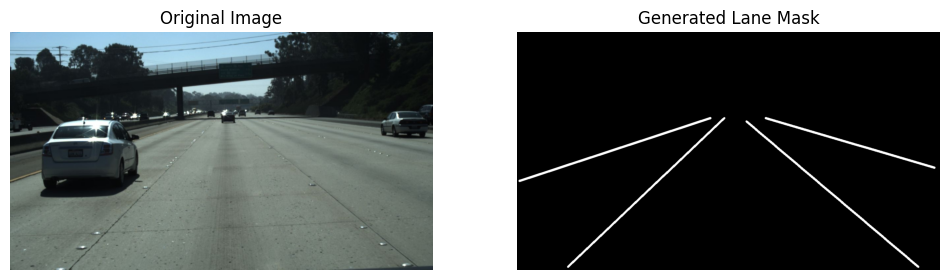

Image Shape: (720, 1280, 3)


In [96]:
def create_lane_mask(lanes, h_samples, image_shape):
    """
    Converts TuSimple lane annotations to a binary mask.

    Arguments:
    - lanes: List of lane x-coordinates (or '-2' for missing points).
    - h_samples: List of y-coordinates corresponding to lane points.
    - image_shape: Shape of the image (H, W, C).

    Returns:
    - mask: Binary lane mask (same height and width as image).
    """
    mask = np.zeros(image_shape[:2], dtype=np.uint8)  # Create blank mask

    # Loop over each lane
    for lane in lanes:
        points = [(x, y) for x, y in zip(lane, h_samples) if x != -2]  # Ignore missing points

        # Draw lane lines
        for i in range(1, len(points)):
            cv2.line(mask, points[i-1], points[i], color=255, thickness=5)  # White lanes

    return mask





def visualize_lane_annotation(index):
    """
    Displays an image and its corresponding lane mask from the TuSimple dataset (CSV version).

    Arguments:
    - index: Row index of `df` to visualize.
    """
    row = df_lane.iloc[index]  # Fetch row from DataFrame

    # Get image path
    image_path = row["image_path"]
    print(image_path)


    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create lane mask
    lane_mask = create_lane_mask(row["lanes"], row["h_samples"], image.shape)

    # Plot the image and mask
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image)
    ax1.set_title("Original Image")
    ax1.axis("off")

    ax2.imshow(lane_mask, cmap="gray")
    ax2.set_title("Generated Lane Mask")
    ax2.axis("off")

    plt.show()
    print(f"Image Shape: {image.shape}")

# Visualize a sample
visualize_lane_annotation(41)


In [78]:
# Create a directory to save masks
mask_dir = "lane_masks"
os.makedirs(mask_dir, exist_ok=True)

# Iterate through all images
for index, row in tqdm(df_lane.iterrows(), total=len(df_lane), desc="Generating Lane Masks"):
    # Get image path
    image_path = row["image_path"]

    # Load the image to get its shape
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not load image at {image_path}, skipping.")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert lane strings to Python lists (if necessary)
    lanes = eval(str(row["lanes"])) if isinstance(row["lanes"], str) else row["lanes"]
    h_samples = eval(str(row["h_samples"])) if isinstance(row["h_samples"], str) else row["h_samples"]

    # Generate lane mask
    lane_mask = create_lane_mask(lanes, h_samples, image.shape)

    # Define mask save path
    mask_filename = os.path.join(mask_dir, f"mask_{index}.png")

    # Save mask
    cv2.imwrite(mask_filename, lane_mask)


Generating Lane Masks: 100%|██████████| 2858/2858 [00:37<00:00, 76.47it/s]


/content/tusimple/TUSimple/train_set/clips/0313-1/36000/20.jpg
lane_masks/mask_5.png
✅ Mask file exists: lane_masks/mask_5.png
/content/tusimple/TUSimple/train_set/clips/0313-1/36000/20.jpg


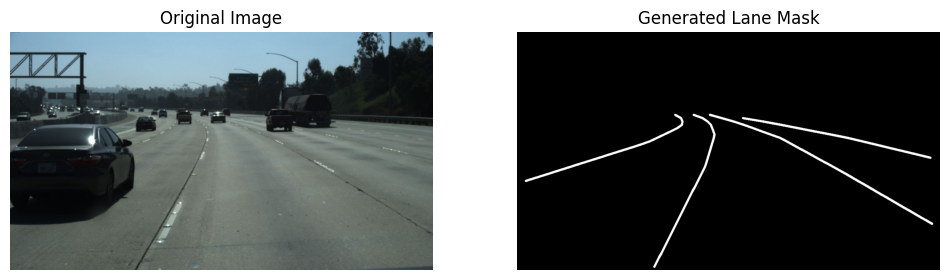

Image Shape: (720, 1280, 3)


In [97]:

import os

# Define base path where images are stored
base_path = "/content/tusimple/TUSimple/train_set/"

# Add full image paths to DataFrame
df_lane["image_path"] = df_lane["raw_file"].apply(lambda x: os.path.join(base_path, x))

df_lane = df_lane.reset_index(drop=True)


# Create corresponding mask paths (assuming we save masks in `masks/` directory)
df_lane["mask_path"] = df_lane.index.map(lambda idx: os.path.join(mask_dir, f"mask_{idx}.png"))

# Display new DataFrame structure

sample_index = 5  # Choose an index within range
print(df_lane.loc[sample_index, "image_path"])  # Should print a valid image path
print(df_lane.loc[sample_index, "mask_path"])  # Should print the correct mask path

import os

mask_path = os.path.join("lane_masks", "mask_5.png")  # Construct the mask path
if os.path.exists(mask_path):
    print(f"✅ Mask file exists: {mask_path}")
else:
    print(f"❌ Mask file is missing: {mask_path}")
visualize_lane_annotation(5)


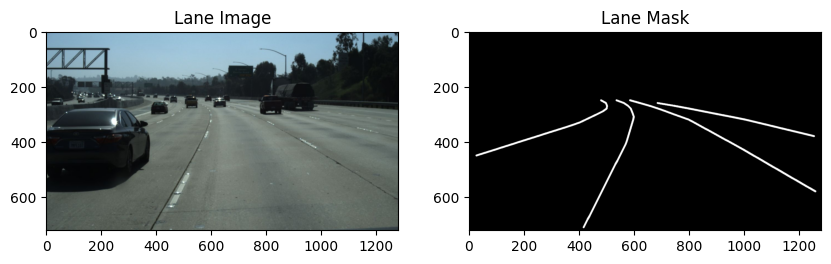

In [111]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = df_lane.loc[sample_index, "image_path"]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the mask
mask_path = df_lane.loc[sample_index, "mask_path"]
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if mask is None:
    print(f"ERROR: Could not load mask at {mask_path}")
else:
    # Display image and mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Lane Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Lane Mask")

    plt.show()


The TuSimple dataset consists of 6,408 road images on US highways. The resolution of the image is 1280×720. The dataset is composed of 3,626 for training, 358 for validation, and 2,782 for testing called the TuSimple test set of which the images are under different weather conditions.

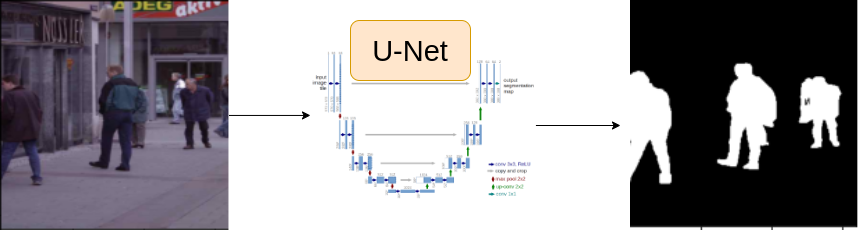

# Some Common Imports

In [24]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

# Task : 2 Setup Configurations

In [26]:
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content/'

device = 'cuda'

EPOCHS  =25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [27]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [48]:
row = df.iloc[5]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0
print(row)

masks     Human-Segmentation-Dataset-master/Ground_Truth...
images    Human-Segmentation-Dataset-master/Training_Ima...
Name: 5, dtype: object


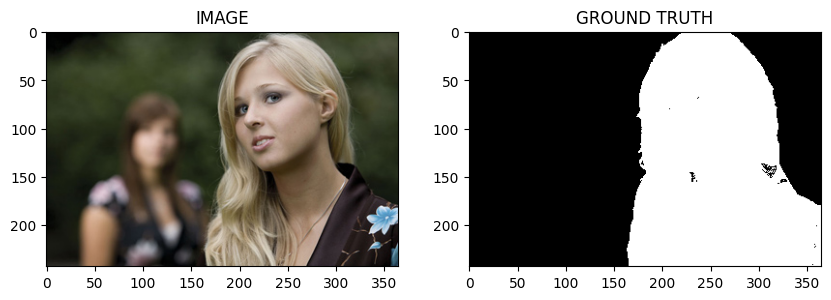

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [32]:
# train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

# Task 2.5 : Mixing the datasets


In [42]:
def resize_image_and_mask(image, mask, target_size=(320, 320)):
    """
    Resizes an image and its corresponding mask to the target size.
    """
    image_resized = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)  # NEAREST for segmentation

    return image_resized, mask_resized

# Example usage


# Task 3 : Augmentation Functions

1.   List item
2.   List item



albumentation documentation : https://albumentations.ai/docs/

In [39]:
import albumentations as A

In [40]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p=0.5),
  ],      is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)

      ],  is_check_shapes=False)


# Task 4 : Create Custom Dataset

In [41]:
from torch.utils.data import Dataset

In [ ]:
# class TuSimpleDataset(Dataset):
#     def __init__(self, json_file, img_dir, transform=None):
#         with open(json_file, 'r') as f:
#             self.annotations = json.load(f)
#         self.img_dir = img_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.annotations)

#     def __getitem__(self, idx):
#         # Load image
#         img_path = self.img_dir + self.annotations[idx]["raw_file"]
#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         # Create blank mask
#         mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

#         # Draw lane markings
#         lanes = self.annotations[idx]["lanes"]
#         for lane in lanes:
#             for (x, y) in zip(lane, range(len(lane))):
#                 if x != -2:  # -2 means no lane point
#                     mask[y, x] = 1  # Mark lane pixels as "1"

#         # Convert to tensors
#         image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1) / 255.0
#         mask = torch.tensor(mask, dtype=torch.long)

#         return image, mask

In [ ]:
# from os import MFD_HUGE_MASK
# class SegmentationDataset(Dataset):

#   def __init__(self, df, augmentations):

#     self.df = df
#     self.augmentations = augmentations

#   def __len__(self):
#     return len(self.df)

#   # now a feature for geting the item by its index
#   def __getitem__(self, idx):
#     row = self.df.iloc[idx]
#     image_path = row.images
#     mask_path = row.masks

#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     mask = np.expand_dims(mask, axis = -1)

#     if self.augmentations:
#       data = self.augmentations(image = image, mask = mask)
#       image = data['image']
#       mask = data['mask']

#       # current format is (h,w,c) and we will change t to (c, h, w)

#       image = np.transpose(image, (2,0,1)).astype(np.float32)
#       mask = np.transpose(mask, (2,0,1)).astype(np.float32)

#       image = torch.Tensor(image)/255.0
#       mask = torch.round(torch.Tensor(mask)/255.0)

#       return image, mask


In [ ]:
# trainset = SegmentationDataset(train_df, get_train_augs())
# validset = SegmentationDataset(valid_df, get_valid_augs())

#

In [98]:
from sklearn.model_selection import train_test_split

# Split Lane Dataset
lane_train, lane_valid = train_test_split(
    df_lane, test_size=0.2, random_state=42
)

# Split Pedestrian Dataset
ped_train, ped_valid = train_test_split(
    df, test_size=0.2, random_state=42
)

print(f"Lane Train: {len(lane_train)}, Lane Valid: {len(lane_valid)}")
print(f"Pedestrian Train: {len(ped_train)}, Pedestrian Valid: {len(ped_valid)}")


Lane Train: 2286, Lane Valid: 572
Pedestrian Train: 232, Pedestrian Valid: 58


In [99]:
import os

# Check first few entries in the dataframe
print(df_lane.head())

# Verify that all mask paths exist
missing_masks = [path for path in df_lane["mask_path"] if not os.path.exists(path)]
print(f"Missing Masks: {len(missing_masks)}")
if missing_masks:
    print("First few missing masks:", missing_masks[:5])


                                               lanes  \
0  [[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...   
1  [[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...   
2  [[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...   
3  [[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...   
4  [[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...   

                                           h_samples  \
0  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
1  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
2  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
3  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
4  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   

                    raw_file  \
0   clips/0313-1/6040/20.jpg   
1   clips/0313-1/5320/20.jpg   
2  clips/0313-1/23700/20.jpg   
3  clips/0313-1/51660/20.jpg   
4  clips/0313-1/25680/20.jpg   

                                          image_path              mask_path  
0  /content/tusimple/TUSimple/train_set/clips/031...  l

In [100]:
# import torch
# from torch.utils.data import Dataset
# import cv2
# import numpy as np
# import glob

# class SingleDataset(Dataset):
#     def __init__(self, image_paths, mask_paths, target_size=(IMAGE_SIZE,IMAGE_SIZE)):
#         """
#         Dataset class for either lane or pedestrian segmentation.
#         Arguments:
#         - image_paths: List of image file paths.
#         - mask_paths: List of mask file paths.
#         - target_size: Target resolution for resizing (height, width).
#         """
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#         self.target_size = target_size

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         """
#         Loads one image and its corresponding mask.
#         """
#         img_path = self.image_paths[idx]
#         mask_path = self.mask_paths[idx]

#         # Load image and mask
#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#         # Resize
#         image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)
#         mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

#         # Convert to PyTorch tensor
#         image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1) / 255.0
#         mask = torch.tensor(mask, dtype=torch.long)

#         return image, mask


In [112]:
# Create individual datasets

lane_train_images = lane_train["image_path"]
lane_train_masks = lane_train["mask_path"]

pedestrian_train_images = ped_train['images']
pedestrian_train_masks = ped_train['masks']



train_lane_dataset = SingleDataset(lane_train_images, lane_train_masks)
train_pedestrian_dataset = SingleDataset(pedestrian_train_images, pedestrian_train_masks)


lane_valid_images = lane_valid['image_path']
lane_valid_masks = lane_valid['mask_path']
pedestrian_valid_images = ped_valid['images']
pedestrian_valid_masks = ped_valid['masks']

valid_lane_dataset = SingleDataset(lane_valid_images, lane_valid_masks)
valid_pedestrian_dataset = SingleDataset(pedestrian_valid_images, pedestrian_valid_masks)



In [113]:
import os

class SingleDataset(Dataset):
    def __init__(self, image_paths, mask_paths, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        #If the mask is None, print a warning and return a blank mask
        if mask is None:
            print(f"Warning: Could not load mask at {mask_path}, replacing with blank mask.")
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # Resize
        image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

        # Convert to PyTorch tensor
        image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1) / 255.0
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask


In [114]:
import random

class MixedDataset(Dataset):
    def __init__(self, lane_dataset, pedestrian_dataset):
        """
        Combines two datasets (lane + pedestrian).
        Arguments:
        - lane_dataset: Instance of `SingleDataset` for lane segmentation.
        - pedestrian_dataset: Instance of `SingleDataset` for pedestrian segmentation.
        """
        self.lane_dataset = lane_dataset
        self.pedestrian_dataset = pedestrian_dataset

    def __len__(self):
        return max(len(self.lane_dataset), len(self.pedestrian_dataset))

    def __getitem__(self, idx):
        """
        Randomly selects from lane or pedestrian dataset.
        """
        if random.random() < 0.5:  # 50% chance for lane dataset
            return self.lane_dataset[idx % len(self.lane_dataset)]
        else:  # 50% chance for pedestrian dataset
            return self.pedestrian_dataset[idx % len(self.pedestrian_dataset)]


In [115]:
# Create individual datasets
train_lane_dataset = SingleDataset(lane_train_images, lane_train_masks)
train_pedestrian_dataset = SingleDataset(pedestrian_train_images, pedestrian_train_masks)

valid_lane_dataset = SingleDataset(lane_valid_images, lane_valid_masks)
valid_pedestrian_dataset = SingleDataset(pedestrian_valid_images, pedestrian_valid_masks)


In [116]:
# Mixed train dataset
train_dataset = MixedDataset(train_lane_dataset, train_pedestrian_dataset)

# Mixed validation dataset
valid_dataset = MixedDataset(valid_lane_dataset, valid_pedestrian_dataset)


In [117]:
print(f"Size of Trainset : {len(train_dataset)}")
print(f"Size of Validset : {len(valid_dataset)}")

Size of Trainset : 2286
Size of Validset : 572


In [118]:
# idx = 32
# image, mask = trainset[idx]
# helper.show_image(image, mask)

In [119]:
# import torch
# from torch.utils.data import Dataset
# import cv2
# import numpy as np
# import random
# import glob

# class LanePedestrianDataset(Dataset):
#     def __init__(self, lane_images, lane_masks, pedestrian_images, pedestrian_masks, target_size=(320,320)):
#         self.lane_images = lane_images
#         self.lane_masks = lane_masks
#         self.pedestrian_images = pedestrian_images
#         self.pedestrian_masks = pedestrian_masks
#         self.target_size = target_size

#     def __len__(self):
#         return max(len(self.lane_images)+len(self.pedestrian_images))  # Use the largest dataset size

#     def __getitem__(self, idx):
#         """
#         Randomly return either a lane image or a pedestrian image with its mask.
#         """
#         if random.random() < 0.5:  # 50% chance to return a lane image
#             img_path = self.lane_images[idx % len(self.lane_images)]
#             mask_path = self.lane_masks[idx % len(self.lane_masks)]
#         else:  # 50% chance to return a pedestrian image
#             img_path = self.pedestrian_images[idx % len(self.pedestrian_images)]
#             mask_path = self.pedestrian_masks[idx % len(self.pedestrian_masks)]

#         # Load image and mask
#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#         # Resize
#         image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)
#         mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

#         # Convert to tensor
#         image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1) / 255.0
#         mask = torch.tensor(mask, dtype=torch.long)

#         return image, mask


# Task 5 : Load dataset into batches

In [120]:
from torch.utils.data import DataLoader

In [121]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# Check batch shapes
for images, masks in train_loader:
    print(f"Train Batch: Image Shape: {images.shape}, Mask Shape: {masks.shape}")
    break

for images, masks in valid_loader:
    print(f"Valid Batch: Image Shape: {images.shape}, Mask Shape: {masks.shape}")
    break


KeyError: 117

In [ ]:
# trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
# validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [55]:
print(f"total no. of trainloader : {len(train_loader)}")
print(f"total no. of validloader : {len(valid_loader)}")

total no. of trainloader : 286
total no. of validloader : 72


In [ ]:
for image,mask in trainloader:
  break
  # print(mask)
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape: {mask.shape}")


One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_chanels = 3,
        classes = 2,   #multi class classifiction of the lanes and the people
        activation = 'softmax'  #for the multiple classes
    )


  def forward(self, images, masks = None):
    logits = self.arc(images)


    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits


In [ ]:
model = SegmentationModel()
model.to(device)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model,optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)



In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(device)
      masks = masks.to(device)

      logits, loss = model(images, masks)
      optimizer.step()

      total_loss += loss.item()

  return total_loss/len(data_loader)



# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.inf


for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saved Best Model!")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1}")
  print(f"Train Loss : {train_loss:.4f}")
  print(f"Valid Loss : {valid_loss:.4f}")

100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Saved Best Model!
Epoch : 1
Train Loss : 0.8111
Valid Loss : 0.6601


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch : 2
Train Loss : 0.7621
Valid Loss : 3.9517


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Epoch : 3
Train Loss : 0.5616
Valid Loss : 1.0698


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Saved Best Model!
Epoch : 4
Train Loss : 0.4805
Valid Loss : 0.5048


100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


Epoch : 5
Train Loss : 0.5933
Valid Loss : 0.6547


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


Saved Best Model!
Epoch : 6
Train Loss : 0.4301
Valid Loss : 0.4334


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Saved Best Model!
Epoch : 7
Train Loss : 0.4474
Valid Loss : 0.3586


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch : 8
Train Loss : 0.4210
Valid Loss : 0.5196


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Epoch : 9
Train Loss : 0.4367
Valid Loss : 0.3675


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Saved Best Model!
Epoch : 10
Train Loss : 0.3616
Valid Loss : 0.2637


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


Epoch : 11
Train Loss : 0.3006
Valid Loss : 0.3819


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Saved Best Model!
Epoch : 12
Train Loss : 0.2539
Valid Loss : 0.2273


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Epoch : 13
Train Loss : 0.2992
Valid Loss : 0.3757


100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


Epoch : 14
Train Loss : 0.4201
Valid Loss : 0.4499


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch : 15
Train Loss : 0.3742
Valid Loss : 0.3335


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Epoch : 16
Train Loss : 0.3552
Valid Loss : 0.3426


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch : 17
Train Loss : 0.3991
Valid Loss : 0.4287


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Epoch : 18
Train Loss : 0.5121
Valid Loss : 0.3824


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Epoch : 19
Train Loss : 0.4523
Valid Loss : 0.4678


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 20
Train Loss : 0.3219
Valid Loss : 0.3016


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Epoch : 21
Train Loss : 0.2730
Valid Loss : 0.3004


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch : 22
Train Loss : 0.2939
Valid Loss : 0.2669


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch : 23
Train Loss : 0.2421
Valid Loss : 0.2496


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Epoch : 24
Train Loss : 0.3230
Valid Loss : 0.3915


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]

Epoch : 25
Train Loss : 0.3092
Valid Loss : 0.2894


# Task 9 : Inference

In [ ]:
idx = 46

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]
print((image.to(device).unsqueeze(0)).shape)
logits_mask = model((image.to(device)).unsqueeze(0))
# the above code transformed c, h, w -> 1, c, h, w
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask >= 0.5)*1.0

torch.Size([1, 3, 320, 320])


<ipython-input-115-da4e5dc08906>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


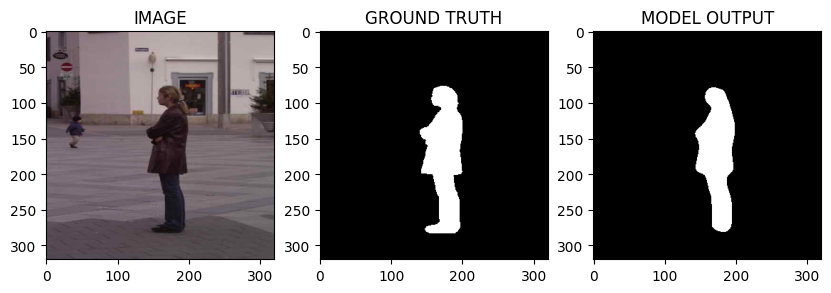

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya